In [1]:
#import logging
#logging.getLogger().setLevel(logging.ERROR)

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data
import itertools
from torch.utils.data import Dataset
import torchani
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.utils import scatter
from rdkit import RDLogger
RDLogger.logger().setLevel(RDLogger.CRITICAL)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from torch_geometric.utils.convert import from_scipy_sparse_matrix

IPythonConsole.ipython_useSVG = True  # Enable SVG rendering
rdDepictor.SetPreferCoordGen(True)  # Ensure molecule coordinates are generated


In [2]:
"""
Module for generating rdkit molobj/smiles/molecular graph from free atoms

Implementation by Jan H. Jensen, based on the paper

    Yeonjoon Kim and Woo Youn Kim
    "Universal Structure Conversion Method for Organic Molecules: From Atomic Connectivity
    to Three-Dimensional Geometry"
    Bull. Korean Chem. Soc. 2015, Vol. 36, 1769-1777
    DOI: 10.1002/bkcs.10334

"""

import copy
import itertools

from rdkit.Chem import rdmolops
from rdkit.Chem import rdchem
try:
    from rdkit.Chem import rdEHTTools #requires RDKit 2019.9.1 or later
except ImportError:
    rdEHTTools = None
    
from collections import defaultdict

import numpy as np
import networkx as nx

from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops
import sys

global __ATOM_LIST__
__ATOM_LIST__ = \
    ['h',  'he',
     'li', 'be', 'b',  'c',  'n',  'o',  'f',  'ne',
     'na', 'mg', 'al', 'si', 'p',  's',  'cl', 'ar',
     'k',  'ca', 'sc', 'ti', 'v ', 'cr', 'mn', 'fe', 'co', 'ni', 'cu',
     'zn', 'ga', 'ge', 'as', 'se', 'br', 'kr',
     'rb', 'sr', 'y',  'zr', 'nb', 'mo', 'tc', 'ru', 'rh', 'pd', 'ag',
     'cd', 'in', 'sn', 'sb', 'te', 'i',  'xe',
     'cs', 'ba', 'la', 'ce', 'pr', 'nd', 'pm', 'sm', 'eu', 'gd', 'tb', 'dy',
     'ho', 'er', 'tm', 'yb', 'lu', 'hf', 'ta', 'w',  're', 'os', 'ir', 'pt',
     'au', 'hg', 'tl', 'pb', 'bi', 'po', 'at', 'rn',
     'fr', 'ra', 'ac', 'th', 'pa', 'u',  'np', 'pu']


global atomic_valence
global atomic_valence_electrons

atomic_valence = defaultdict(list)
atomic_valence[1] = [1]
atomic_valence[5] = [3,4]
atomic_valence[6] = [4]
atomic_valence[7] = [3,4]
atomic_valence[8] = [2,1,3]
atomic_valence[9] = [1]
atomic_valence[14] = [4]
atomic_valence[15] = [5,3] #[5,4,3]
atomic_valence[16] = [6,3,2] #[6,4,2]
atomic_valence[17] = [1]
atomic_valence[32] = [4]
atomic_valence[35] = [1]
atomic_valence[53] = [1]

atomic_valence_electrons = {}
atomic_valence_electrons[1] = 1
atomic_valence_electrons[5] = 3
atomic_valence_electrons[6] = 4
atomic_valence_electrons[7] = 5
atomic_valence_electrons[8] = 6
atomic_valence_electrons[9] = 7
atomic_valence_electrons[14] = 4
atomic_valence_electrons[15] = 5
atomic_valence_electrons[16] = 6
atomic_valence_electrons[17] = 7
atomic_valence_electrons[32] = 4
atomic_valence_electrons[35] = 7
atomic_valence_electrons[53] = 7


def str_atom(atom):
    """
    convert integer atom to string atom
    """
    global __ATOM_LIST__
    atom = __ATOM_LIST__[atom - 1]
    return atom


def int_atom(atom):
    """
    convert str atom to integer atom
    """
    global __ATOM_LIST__
    #print(atom)
    atom = atom.lower()
    return __ATOM_LIST__.index(atom) + 1


def get_UA(maxValence_list, valence_list):
    """
    """
    UA = []
    DU = []
    for i, (maxValence, valence) in enumerate(zip(maxValence_list, valence_list)):
        if not maxValence - valence > 0:
            continue
        UA.append(i)
        DU.append(maxValence - valence)
    return UA, DU


def get_BO(AC, UA, DU, valences, UA_pairs, use_graph=True):
    """
    """
    BO = AC.copy()
    DU_save = []

    while DU_save != DU:
        for i, j in UA_pairs:
            BO[i, j] += 1
            BO[j, i] += 1

        BO_valence = list(BO.sum(axis=1))
        DU_save = copy.copy(DU)
        UA, DU = get_UA(valences, BO_valence)
        UA_pairs = get_UA_pairs(UA, AC, use_graph=use_graph)[0]

    return BO


def valences_not_too_large(BO, valences):
    """
    """
    number_of_bonds_list = BO.sum(axis=1)
    for valence, number_of_bonds in zip(valences, number_of_bonds_list):
        if number_of_bonds > valence:
            return False

    return True

def charge_is_OK(BO, AC, charge, DU, atomic_valence_electrons, atoms, valences,
                 allow_charged_fragments=True):
    # total charge
    Q = 0
    # charge fragment list
    q_list = []

    if allow_charged_fragments:

        BO_valences = list(BO.sum(axis=1))
        for i, atom in enumerate(atoms):
            q = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
            Q += q
            if atom == 6:
                number_of_single_bonds_to_C = list(BO[i, :]).count(1)
                if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                    Q += 1
                    q = 2
                if number_of_single_bonds_to_C == 3 and Q + 1 < charge:
                    Q += 2
                    q = 1

            if q != 0:
                q_list.append(q)

    return (charge == Q)

def BO_is_OK(BO, AC, charge, DU, atomic_valence_electrons, atoms, valences,
    allow_charged_fragments=True):
    """
    Sanity of bond-orders

    args:
        BO -
        AC -
        charge -
        DU - 


    optional
        allow_charges_fragments - 


    returns:
        boolean - true of molecule is OK, false if not
    """
    if not valences_not_too_large(BO, valences):
        return False

    check_sum = (BO - AC).sum() == sum(DU)
    check_charge = charge_is_OK(BO, AC, charge, DU, atomic_valence_electrons, atoms, valences,
                                allow_charged_fragments)

    if check_charge and check_sum: 
        return True

    return False


def get_atomic_charge(atom, atomic_valence_electrons, BO_valence):
    """
    """
    if atom == 1:
        charge = 1 - BO_valence
    elif atom == 5:
        charge = 3 - BO_valence
    elif atom == 15 and BO_valence == 5:
        charge = 0
    elif atom == 16 and BO_valence == 6:
        charge = 0
    else:
        charge = atomic_valence_electrons - 8 + BO_valence

    return charge


def clean_charges(mol):
    """
    This hack should not be needed anymore, but is kept just in case

    """
    Chem.SanitizeMol(mol)
    #rxn_smarts = ['[N+:1]=[*:2]-[C-:3]>>[N+0:1]-[*:2]=[C-0:3]',
    #              '[N+:1]=[*:2]-[O-:3]>>[N+0:1]-[*:2]=[O-0:3]',
    #              '[N+:1]=[*:2]-[*:3]=[*:4]-[O-:5]>>[N+0:1]-[*:2]=[*:3]-[*:4]=[O-0:5]',
    #              '[#8:1]=[#6:2]([!-:6])[*:3]=[*:4][#6-:5]>>[*-:1][*:2]([*:6])=[*:3][*:4]=[*+0:5]',
    #              '[O:1]=[c:2][c-:3]>>[*-:1][*:2][*+0:3]',
    #              '[O:1]=[C:2][C-:3]>>[*-:1][*:2]=[*+0:3]']

    rxn_smarts = ['[#6,#7:1]1=[#6,#7:2][#6,#7:3]=[#6,#7:4][CX3-,NX3-:5][#6,#7:6]1=[#6,#7:7]>>'
                  '[#6,#7:1]1=[#6,#7:2][#6,#7:3]=[#6,#7:4][-0,-0:5]=[#6,#7:6]1[#6-,#7-:7]',
                  '[#6,#7:1]1=[#6,#7:2][#6,#7:3](=[#6,#7:4])[#6,#7:5]=[#6,#7:6][CX3-,NX3-:7]1>>'
                  '[#6,#7:1]1=[#6,#7:2][#6,#7:3]([#6-,#7-:4])=[#6,#7:5][#6,#7:6]=[-0,-0:7]1']

    fragments = Chem.GetMolFrags(mol,asMols=True,sanitizeFrags=False)

    for i, fragment in enumerate(fragments):
        for smarts in rxn_smarts:
            patt = Chem.MolFromSmarts(smarts.split(">>")[0])
            while fragment.HasSubstructMatch(patt):
                rxn = AllChem.ReactionFromSmarts(smarts)
                ps = rxn.RunReactants((fragment,))
                fragment = ps[0][0]
                Chem.SanitizeMol(fragment)
        if i == 0:
            mol = fragment
        else:
            mol = Chem.CombineMols(mol, fragment)

    return mol


def BO2mol(mol, BO_matrix, atoms, atomic_valence_electrons,
           mol_charge, allow_charged_fragments=True,  use_atom_maps=False):
    """
    based on code written by Paolo Toscani

    From bond order, atoms, valence structure and total charge, generate an
    rdkit molecule.

    args:
        mol - rdkit molecule
        BO_matrix - bond order matrix of molecule
        atoms - list of integer atomic symbols
        atomic_valence_electrons -
        mol_charge - total charge of molecule

    optional:
        allow_charged_fragments - bool - allow charged fragments

    returns
        mol - updated rdkit molecule with bond connectivity

    """
    l = len(BO_matrix)
    l2 = len(atoms)
    BO_valences = list(BO_matrix.sum(axis=1))

    if (l != l2):
        raise RuntimeError('sizes of adjMat ({0:d}) and Atoms {1:d} differ'.format(l, l2))

    rwMol = Chem.RWMol(mol)

    bondTypeDict = {
        1: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE
    }

    for i in range(l):
        for j in range(i + 1, l):
            bo = int(round(BO_matrix[i, j]))
            if (bo == 0):
                continue
            bt = bondTypeDict.get(bo, Chem.BondType.SINGLE)
            rwMol.AddBond(i, j, bt)

    mol = rwMol.GetMol()

    if allow_charged_fragments:
        mol = set_atomic_charges(
            mol,
            atoms,
            atomic_valence_electrons,
            BO_valences,
            BO_matrix,
            mol_charge,
            use_atom_maps)
    else:
        mol = set_atomic_radicals(mol, atoms, atomic_valence_electrons, BO_valences,
                                                            use_atom_maps)

    return mol


def set_atomic_charges(mol, atoms, atomic_valence_electrons,
                       BO_valences, BO_matrix, mol_charge,
                       use_atom_maps):
    """
    """
    q = 0
    for i, atom in enumerate(atoms):
        a = mol.GetAtomWithIdx(i)
        if use_atom_maps:
            a.SetAtomMapNum(i+1)
        charge = get_atomic_charge(atom, atomic_valence_electrons[atom], BO_valences[i])
        q += charge
        if atom == 6:
            number_of_single_bonds_to_C = list(BO_matrix[i, :]).count(1)
            if number_of_single_bonds_to_C == 2 and BO_valences[i] == 2:
                q += 1
                charge = 0
            if number_of_single_bonds_to_C == 3 and q + 1 < mol_charge:
                q += 2
                charge = 1

        if (abs(charge) > 0):
            a.SetFormalCharge(int(charge))

    #mol = clean_charges(mol)

    return mol


def set_atomic_radicals(mol, atoms, atomic_valence_electrons, BO_valences,
                                                use_atom_maps):
    """

    The number of radical electrons = absolute atomic charge

    """
    for i, atom in enumerate(atoms):
        a = mol.GetAtomWithIdx(i)
        if use_atom_maps:
            a.SetAtomMapNum(i+1)
        charge = get_atomic_charge(
            atom,
            atomic_valence_electrons[atom],
            BO_valences[i])

        if (abs(charge) > 0):
            a.SetNumRadicalElectrons(abs(int(charge)))

    return mol


def get_bonds(UA, AC):
    """

    """
    bonds = []

    for k, i in enumerate(UA):
        for j in UA[k + 1:]:
            if AC[i, j] == 1:
                bonds.append(tuple(sorted([i, j])))

    return bonds


def get_UA_pairs(UA, AC, use_graph=True):
    """

    """
    bonds = get_bonds(UA, AC)

    if len(bonds) == 0:
        return [()]

    if use_graph:
        G = nx.Graph()
        G.add_edges_from(bonds)
        UA_pairs = [list(nx.max_weight_matching(G))]
        return UA_pairs

    max_atoms_in_combo = 0
    UA_pairs = [()]
    for combo in list(itertools.combinations(bonds, int(len(UA) / 2))):
        flat_list = [item for sublist in combo for item in sublist]
        atoms_in_combo = len(set(flat_list))
        if atoms_in_combo > max_atoms_in_combo:
            max_atoms_in_combo = atoms_in_combo
            UA_pairs = [combo]

        elif atoms_in_combo == max_atoms_in_combo:
            UA_pairs.append(combo)

    return UA_pairs


def AC2BO(AC, atoms, charge, allow_charged_fragments=True, use_graph=True):
    """

    implemenation of algorithm shown in Figure 2

    UA: unsaturated atoms

    DU: degree of unsaturation (u matrix in Figure)

    best_BO: Bcurr in Figure

    """
    global atomic_valence
    global atomic_valence_electrons

    # make a list of valences, e.g. for CO: [[4],[2,1]]
    valences_list_of_lists = []
    AC_valence = list(AC.sum(axis=1))
    
    for i,(atomicNum,valence) in enumerate(zip(atoms,AC_valence)):
        # valence can't be smaller than number of neighbourgs
        possible_valence = [x for x in atomic_valence[atomicNum] if x >= valence]
        if not possible_valence:
            print('Valence of atom',i,'is',valence,'which bigger than allowed max',max(atomic_valence[atomicNum]),'. Stopping')
            sys.exit()
        valences_list_of_lists.append(possible_valence)

    # convert [[4],[2,1]] to [[4,2],[4,1]]
    valences_list = itertools.product(*valences_list_of_lists)

    best_BO = AC.copy()

    for valences in valences_list:

        UA, DU_from_AC = get_UA(valences, AC_valence)

        check_len = (len(UA) == 0)
        if check_len:
            check_bo = BO_is_OK(AC, AC, charge, DU_from_AC,
                atomic_valence_electrons, atoms, valences,
                allow_charged_fragments=allow_charged_fragments)
        else:
            check_bo = None

        if check_len and check_bo:
            return AC, atomic_valence_electrons

        UA_pairs_list = get_UA_pairs(UA, AC, use_graph=use_graph)
        for UA_pairs in UA_pairs_list:
            BO = get_BO(AC, UA, DU_from_AC, valences, UA_pairs, use_graph=use_graph)
            status = BO_is_OK(BO, AC, charge, DU_from_AC,
                        atomic_valence_electrons, atoms, valences,
                        allow_charged_fragments=allow_charged_fragments)
            charge_OK = charge_is_OK(BO, AC, charge, DU_from_AC, atomic_valence_electrons, atoms, valences,
                                     allow_charged_fragments=allow_charged_fragments)

            if status:
                return BO, atomic_valence_electrons
            elif BO.sum() >= best_BO.sum() and valences_not_too_large(BO, valences) and charge_OK:
                best_BO = BO.copy()

    return best_BO, atomic_valence_electrons


def AC2mol(mol, AC, atoms, charge, allow_charged_fragments=True, 
           use_graph=True, use_atom_maps=False):
    """
    """
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    # convert AC matrix to bond order (BO) matrix
    BO, atomic_valence_electrons = AC2BO(
        AC,
        atoms,
        charge,
        allow_charged_fragments=allow_charged_fragments,
        use_graph=use_graph)

    # add BO connectivity and charge info to mol object
    mol = BO2mol(
        mol,
        BO,
        atoms,
        atomic_valence_electrons,
        charge,
        allow_charged_fragments=allow_charged_fragments,
        use_atom_maps=use_atom_maps)

    # If charge is not correct don't return mol
    if Chem.GetFormalCharge(mol) != charge:
        return []

    # BO2mol returns an arbitrary resonance form. Let's make the rest
    mols = rdchem.ResonanceMolSupplier(mol, Chem.UNCONSTRAINED_CATIONS, Chem.UNCONSTRAINED_ANIONS)
    mols = [mol for mol in mols]

    return mols


def get_proto_mol(atoms):
    """
    """
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.WARNING)

    mol = Chem.MolFromSmarts("[#" + str(atoms[0]) + "]")
    rwMol = Chem.RWMol(mol)
    for i in range(1, len(atoms)):
        a = Chem.Atom(atoms[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def read_xyz_file(filename, look_for_charge=True):
    """
    """
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    atomic_symbols = []
    xyz_coordinates = []
    charge = 0
    title = ""

    with open(filename, "r") as file:
        for line_number, line in enumerate(file):
            if line_number == 0:
                num_atoms = int(line)
            elif line_number == 1:
                title = line
                if "charge=" in line:
                    charge = int(line.split("=")[1])
            else:
                atomic_symbol, x, y, z = line.split()
                atomic_symbols.append(atomic_symbol)
                xyz_coordinates.append([float(x), float(y), float(z)])

    atoms = [int_atom(atom) for atom in atomic_symbols]

    return atoms, charge, xyz_coordinates


def xyz2AC(atoms, xyz, charge, use_huckel=False):
    """

    atoms and coordinates to atom connectivity (AC)

    args:
        atoms - int atom types
        xyz - coordinates
        charge - molecule charge

    optional:
        use_huckel - Use Huckel method for atom connecitivty

    returns
        ac - atom connectivity matrix
        mol - rdkit molecule

    """
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    if use_huckel:
        return xyz2AC_huckel(atoms, xyz, charge)
    else:
        return xyz2AC_vdW(atoms, xyz)


def xyz2AC_vdW(atoms, xyz):
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    # Get mol template
    mol = get_proto_mol(atoms)

    # Set coordinates
    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i, (xyz[i][0], xyz[i][1], xyz[i][2]))
    mol.AddConformer(conf)

    AC = get_AC(mol)

    return AC, mol


def get_AC(mol, covalent_factor=1.3):
    """

    Generate adjacent matrix from atoms and coordinates.

    AC is a (num_atoms, num_atoms) matrix with 1 being covalent bond and 0 is not


    covalent_factor - 1.3 is an arbitrary factor

    args:
        mol - rdkit molobj with 3D conformer

    optional
        covalent_factor - increase covalent bond length threshold with facto

    returns:
        AC - adjacent matrix

    """
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    # Calculate distance matrix
    dMat = Chem.Get3DDistanceMatrix(mol)

    pt = Chem.GetPeriodicTable()
    num_atoms = mol.GetNumAtoms()
    AC = np.zeros((num_atoms, num_atoms), dtype=int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum()) * covalent_factor
        for j in range(i + 1, num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum()) * covalent_factor
            if dMat[i, j] <= Rcov_i + Rcov_j:
                AC[i, j] = 1
                AC[j, i] = 1

    return AC


def xyz2AC_huckel(atomicNumList, xyz, charge):
    """

    args
        atomicNumList - atom type list
        xyz - coordinates
        charge - molecule charge

    returns
        ac - atom connectivity
        mol - rdkit molecule

    """
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(xyz[i][0],xyz[i][1],xyz[i][2]))
    mol.AddConformer(conf)

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    mol_huckel = Chem.Mol(mol)
    mol_huckel.GetAtomWithIdx(0).SetFormalCharge(charge) #mol charge arbitrarily added to 1st atom    

    passed,result = rdEHTTools.RunMol(mol_huckel)
    opop = result.GetReducedOverlapPopulationMatrix()
    tri = np.zeros((num_atoms, num_atoms))
    tri[np.tril(np.ones((num_atoms, num_atoms), dtype=bool))] = opop #lower triangular to square matrix
    for i in range(num_atoms):
        for j in range(i+1,num_atoms):
            pair_pop = abs(tri[j,i])   
            if pair_pop >= 0.15: #arbitry cutoff for bond. May need adjustment
                AC[i,j] = 1
                AC[j,i] = 1
        
    return AC, mol


def chiral_stereo_check(mol):
    """
    Find and embed chiral information into the model based on the coordinates

    args:
        mol - rdkit molecule, with embeded conformer

    """
    Chem.SanitizeMol(mol)
    Chem.DetectBondStereochemistry(mol, -1)
    Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    Chem.AssignAtomChiralTagsFromStructure(mol, -1)

    return


def xyz2mol(atoms, coordinates, charge=0, allow_charged_fragments=True,
            use_graph=True, use_huckel=False, embed_chiral=True,
            use_atom_maps=False):
    """
    Generate a rdkit molobj from atoms, coordinates and a total_charge.

    args:
        atoms - list of atom types (int)
        coordinates - 3xN Cartesian coordinates
        charge - total charge of the system (default: 0)

    optional:
        allow_charged_fragments - alternatively radicals are made
        use_graph - use graph (networkx)
        use_huckel - Use Huckel method for atom connectivity prediction
        embed_chiral - embed chiral information to the molecule

    returns:
        mols - list of rdkit molobjects

    """
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    # Get atom connectivity (AC) matrix, list of atomic numbers, molecular charge,
    # and mol object with no connectivity information
    AC, mol = xyz2AC(atoms, coordinates, charge, use_huckel=use_huckel)

    # Convert AC to bond order matrix and add connectivity and charge info to
    # mol object
    new_mols = AC2mol(mol, AC, atoms, charge,
                     allow_charged_fragments=allow_charged_fragments,
                     use_graph=use_graph,
                     use_atom_maps=use_atom_maps)

    # Check for stereocenters and chiral centers
    if embed_chiral:
        for new_mol in new_mols:
            chiral_stereo_check(new_mol)

    return new_mols





In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

In [3]:
def load_ani_dataset(dspath):

    
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']
    
    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("/global/scratch/users/timp/datasets/ani_gdb_s01_to_s04.h5")
print(dataset)
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [8]:
batch_size = 8192
# use dataset.collate(...).cache() method to do batching
train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()


In [95]:
def preprocess_data(item):
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    species_labels = [[1, 6, 7, 8][i] for i in item['species']]
    coord_list = item['coordinates'].tolist()
    energy = item['energies'].tolist()
    
    encoder = GraphEncoder()
    try:

        mol = xyz2mol(species_labels, coord_list, 0, use_huckel=True)
        if mol is None:
            return None
    except SystemExit:
        print("Error: xyz2mol function raised SystemExit")
        return None
    if len(mol) == 1:
        node_features, edge_features, edge_index = encoder.encode(mol[0])
        return Data(x=node_features, edge_attr=edge_features, edge_index=edge_index, y=energy)

def create_dataloader(dataset, batch_size=8192, shuffle=True):
    lg = RDLogger.logger()

    lg.setLevel(RDLogger.CRITICAL)

    preprocessed_data = [preprocess_data(item) for item in dataset]
    filtered_data = list(filter(lambda x: x is not None, preprocessed_data))
    dataloader = GraphDataLoader(filtered_data, batch_size=batch_size, shuffle=shuffle)

    return dataloader
    return preprocessed_data


In [4]:
def one_hot_encode(species):
    categories = [0, 1, 2, 3]
    num_samples = len(species)
    num_categories = len(categories)
    node_feature = torch.zeros((num_samples, num_categories), dtype=torch.float32)
    for i, s in enumerate(species):
        if s in categories:
            idx = categories.index(s)
            node_feature[i, idx] = 1
    
    return node_feature

def transform(d):
    coords = torch.tensor(d['coordinates'], dtype=torch.float32)
    species = torch.tensor(d['species'], dtype=torch.float32)
    energy = torch.tensor(d['energies'], dtype=torch.float32)
    
    node_feature = one_hot_encode(d['species'])
    edge_index = torch.tensor(
        list(itertools.permutations(range(coords.shape[0]), 2)), 
    ).T
    edge_feature = 1 / torch.sqrt(
        torch.sum(
            (coords[edge_index[0]] - coords[edge_index[1]]) ** 2, 
            axis=1, keepdim=True
        )
    )

    graph_data = Data(x=node_feature,
                 edge_index=edge_index,
                 edge_attr=edge_feature,
                 y=energy
                     )
    return graph_data
        

In [9]:
batch_size = 2048

In [5]:
graph_ani_train = [transform(d) for d in train_data]

In [6]:
graph_ani_test = [transform(d) for d in test_data]

In [7]:
graph_ani_val = [transform(d) for d in val_data]

In [10]:
graph_ani_train_loader = GraphDataLoader(graph_ani_train, batch_size=batch_size, shuffle=True)

In [11]:
graph_ani_test_loader = GraphDataLoader(graph_ani_test, batch_size=batch_size, shuffle=True)

In [12]:
graph_ani_val_loader = GraphDataLoader(graph_ani_val, batch_size=batch_size, shuffle=True)

In [3]:
class GraphEncoder:
    def __init__(self):
        self.node_features = torch.empty(0, dtype=torch.float32)
        self.edge_features = torch.empty(0, dtype=torch.float32)
        self.adjacency_matrix = None
    


    def encode(self, mol):
        #compute partial charges, I want to use these as a feature.  
        #Might make sense to normalize them and use the charge distribution as node features,
        #as opposed to the 
        if mol is None:
            return None
        for atom in mol.GetAtoms():
            atom_feat = self.encode_atom(atom)
            self.node_features = torch.cat((self.node_features, atom_feat.unsqueeze(0)), dim=0)
        #Extract edge features from bonds
        for bond in mol.GetBonds():
            bond_feat = self.encode_bond(bond)
            self.edge_features = torch.cat((self.edge_features, bond_feat.unsqueeze(0)), dim=0)

        self.adjacency_matrix = torch.tensor(Chem.GetAdjacencyMatrix(mol), dtype=torch.float32)
        row_indices, col_indices = torch.nonzero(self.adjacency_matrix.triu(), as_tuple=True)

        #Get edge_indices
        self.edge_index = torch.stack([row_indices, col_indices], dim=0)
        
        return self.node_features, self.edge_features, self.edge_index

    def encode_atom(self, atom):
        #One hot encode hybridization, whether atom is in aromatic system, whether it is in ring system,
        #and the atomic number.
        atom_num = atom.GetAtomicNum()
        atom_hybridization = self.one_hot_encode(str(atom.GetHybridization()), ['S', 'SP', 'SP2', 'SP3'])
        #atom_aromaticity = self.one_hot_encode(int(atom.GetIsAromatic()), [1, 0])
        #atom_ring = self.one_hot_encode(int(atom.IsInRing()), [1, 0])
        atom_type = self.one_hot_encode(int(atom.GetAtomicNum()), [8, 7, 6, 1])
        #I am using the scaled mass, VdW and covalent radii as 'continuous' node features.
        atom_feat = torch.cat(( #One-hot-encoded properties
            atom_hybridization, 
            #atom_aromaticity, aromaticity irrelevant with 4 heavy atoms
            #atom_ring, presence in ring is irrelevant with 4 heavy atoms
            atom_type, 
            torch.tensor([ #floating point properties
                atom.GetMass()/15.999,
                Chem.GetPeriodicTable().GetRvdw(atom_num),
                Chem.GetPeriodicTable().GetRcovalent(atom_num)
            ], dtype=torch.float32)))

        return atom_feat

    def encode_bond(self, bond):
        #one hot encode a few binary properties and the bond type (single, double, etc). 
        #bond 'type' of 1.5 implies an aromatic bond (like in benzene (this is the hexagon molecule with three lines))
        bond_conj = int(bond.GetIsConjugated())
        #bond_aromaticity = self.one_hot_encode(int(bond.GetIsAromatic()), [1, 0])
        bond_type_oh = self.one_hot_encode(bond.GetBondTypeAsDouble(), [1.5, 1.0, 2.0, 3.0])
        #print(f"encoded bond type: {bond_type_oh}")
        bond_feat = torch.cat((
            torch.tensor([
                bond_conj
                         ], dtype=torch.float32), 
            #bond_aromaticity, bond aromaticity is irrelevant with only four heavy atoms
            bond_type_oh
        ))

        return bond_feat

    def one_hot_encode(self, value, options):
        #Might make sense to reimplement using scipy one hot encoder
        encoded = torch.zeros(len(options))
        if value in options:
            encoded[options.index(value)] = 1
        
        return encoded
        

    #def get_graph_representation(self):
        #This function unnecessary unless I want to make a adjacency matrix representation.
    #    return self.node_features, self.edge_features, self.adjacency_matrix
        

In [ ]:
node_hidden_dim = 128
edge_hidden_dim = 128

net = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim).to(device)

In [14]:
class Layer(nn.Module):
    """
    Basic layer, a linear layer with a ReLU activation 
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim), # linear layer
            nn.LeakyReLU() # relu
        )
    
    def forward(self, x):
        return self.layers(x)
    
    
class MessagePassingLayer(nn.Module):
    """
    A message passing layer that updates nodes/edge features
    """
    def __init__(self, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        # figure out the input/output dimension
        self.edge_net = Layer(2 * node_hidden_dim + edge_hidden_dim, edge_hidden_dim)
        # figure out the input/output dimension
        self.node_net = Layer(node_hidden_dim + edge_hidden_dim, node_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index):
        """
        Update node and edge features
        
        Parameters
        ----------
        node_features: torch.Tensor
            Node features from the previous layer
        edge_features: torch.Tensor
            Edge features from the previous layer
        edge_index: torch.Tensor
            A sparse matrix (n_edge, 2) in which each column denotes node indices forming an edge
        """
        # concatnate previous edge features with node features forming the edge
        # hint: use node_features[edge_index[0(or 1)]] to get node features forming the edge
        concate_edge_features = torch.cat([
            node_features[edge_index[0]], # features of one node
            node_features[edge_index[1]], # features of the other node
            edge_features # previous edge features
        ], dim=1)
        
        # pass through the "edge_net" to map it back to the original dimension
        updated_edge_features = self.edge_net(concate_edge_features)
        
        
        # use scatter to aggrate the edge features to nodes
        aggr_edge_features = scatter(updated_edge_features, edge_index[0], dim_size=node_features.size(0))
        # concatenate it with previous node features
        concate_node_features = torch.cat([aggr_edge_features, node_features], dim=1)
        # pass through the "node_net" to map it back to the original dimension
        updated_node_features = self.node_net(concate_node_features)
        
        return updated_node_features, updated_edge_features

#class GraphConvBlock(nn.Module):
#    def__init__(self, 


class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        # embed the input node features
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        # embed the input edge features
        self.edge_embed = Layer(edge_input_dim, edge_hidden_dim)
        # use a linear layer as readout to get the "atomic" energy contribution
        self.readout = nn.Linear(node_hidden_dim, 1)
        # message passing layer
        self.message_passing = MessagePassingLayer(node_hidden_dim, edge_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index, batch):
        """
        Update node and edge features
        
        Parameters
        ----------
        node_features: torch.Tensor
            Node features from the previous layer
        edge_features: torch.Tensor
            Edge features from the previous layer
        edge_index: torch.Tensor
            A sparse matrix (n_edges, 2) in which each column denotes node indices forming an edge
        batch: torch.Tensor
            A 1-D tensor (n_nodes,) that tells you each node belongs to which graph
        """
        node_hidden = self.node_embed(node_features) # call the node embedding
        edge_hidden = self.edge_embed(edge_features) # call the edge embedding
        #node_hidden = self.conv_block(node_hidden, edge_index)
        updated_node_hidden, updated_edge_hidden = self.message_passing(
            node_hidden,
            edge_hidden,
            edge_index
        ) # call the message passing layer
        readout = self.readout(updated_node_hidden) # use the readout layer to output "atomic" contributions
        out = scatter(readout, batch.to(readout.device)) # use the scatter function to aggregate atomic readouts
        return out
        

In [13]:
class GNNTrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model.to(device)
        self.loss = nn.MSELoss()
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch

    def train(self, train_loader, val_loader, early_stop=True, draw_curve=True):
        self.model.train()
        train_loss_list, val_loss_list, lowest_val_loss = [], [], np.inf
        #loader = GraphDataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        loss_func = self.loss
        batch_loss_list = []
        for i in tqdm(range(self.epoch)):
            train_epoch_loss = 0.0
            #print(f"Epoch: {i}")

            for batch_data in train_loader:
                batch_size = batch_data.y.shape[0]
                node_features = batch_data.x.to(device)
                edge_features = batch_data.edge_attr.to(device)
                edge_index = batch_data.edge_index.to(device)
                batch_pred = self.model(node_features, edge_features, edge_index, batch_data.batch).to(device)
                batch_loss = loss_func(batch_pred, batch_data.y.unsqueeze(1).float())

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_importance = batch_pred.shape[0]/len(train_loader.dataset)
                batch_loss_list.append(batch_loss.detach().cpu().numpy())
                train_epoch_loss += batch_loss.detach().to(device).item()*batch_importance

            val_epoch_loss = self.evaluate(val_loader, draw_plot=False)
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)

            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            x_axis = np.arange(self.epoch)
            # Plot train loss and validation loss
            ax.plot(x_axis, train_loss_list, label='Train')
            ax.plot(x_axis, val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        
        return batch_loss_list
    
    def evaluate(self, loader, draw_plot=True):
        self.model.eval()
        #loader = GraphDataLoader(dataset, batch_size=self.batch_size)
        true_energies_all, pred_energies_all = [], []
        loss_func = self.loss
        total_loss = 0.0

        
        with torch.no_grad():
            for batch_data in loader:
                node_features = batch_data.x.to(device)
                edge_features = batch_data.edge_attr.to(device)
                edge_index = batch_data.edge_index.to(device)
                batch = batch_data.batch
                batch_pred = self.model(node_features, edge_features, edge_index, batch).to(device)
                #print(f"batch_pred: {batch_pred}")
                batch_true = batch_data.y.to(device)
                batch_loss = loss_func(batch_pred, batch_true.unsqueeze(1).float())
                #print(f"batch_true: {batch_true}")
                
                batch_importance = 1 / len(loader.dataset)
                
                total_loss += batch_loss.detach().to(device).item() * batch_importance
                
                if draw_plot:
                    pred_energies_all.append(batch_pred.detach().cpu().numpy().flatten())
                    true_energies_all.append(batch_data.y.detach().cpu().numpy().flatten())
                
        
        
        
        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            #mse = np.mean((true_energies_all - pred_energies_all) ** 2)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f}", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

In [6]:
lg.setLevel(RDLogger.ERROR)
RDLogger.logger().setLevel(RDLogger.CRITICAL)


In [97]:
train_1, train_2, train_3, train_4 = train_data.split(0.25, 0.25, 0.25, 0.25)

In [100]:
lg.setLevel(RDLogger.ERROR)
RDLogger.logger().setLevel(RDLogger.CRITICAL)

graph_train_1 = create_dataloader(train_1)

torch.save(graph_train_1.dataset, '/global/scratch/users/timp/datasets/graph_train_data_1.pt')


Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which

In [101]:
lg.setLevel(RDLogger.ERROR)
RDLogger.logger().setLevel(RDLogger.CRITICAL)

graph_train_2 = create_dataloader(train_2)

torch.save(graph_train_2.dataset, '/global/scratch/users/timp/datasets/graph_train_data_2.pt')

Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which

In [102]:
lg.setLevel(RDLogger.ERROR)
RDLogger.logger().setLevel(RDLogger.CRITICAL)

graph_train_3 = create_dataloader(train_3)

torch.save(graph_train_3.dataset, '/global/scratch/users/timp/datasets/graph_train_data_3.pt')

Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which

In [103]:
lg.setLevel(RDLogger.ERROR)
RDLogger.logger().setLevel(RDLogger.CRITICAL)

graph_train_4 = create_dataloader(train_4)

torch.save(graph_train_4.dataset, '/global/scratch/users/timp/datasets/graph_train_data_4.pt')

Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which

In [175]:
lg.setLevel(RDLogger.ERROR)
graph_val = create_dataloader(val_data)
torch.save(graph_val.dataset, '/global/scratch/users/timp/datasets/graph_val_data.pt')

Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 9 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which

In [105]:
lg.setLevel(RDLogger.ERROR)
graph_test = create_dataloader(test_data)
torch.save(graph_test.dataset, '/global/scratch/users/timp/datasets/graph_test_data.pt')

Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 5 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit
Valence of atom 4 is 2 which bigger than allowed max 1 . Stopping
Error: xyz2mol function raised SystemExit


In [27]:
torch.save(graph_test, 'graph_test.pt')

In [18]:
def make_dataloader(dataset, batch_size=8192, shuffle=True):
    
    filtered_data = list(filter(lambda x: x is not None, dataset))
    dataloader = GraphDataLoader(filtered_data, batch_size=batch_size, shuffle=shuffle)

    return dataloader

def move_data_to_device(dataloader, device):
    for data in dataloader.dataset:
        data = data.to(device)
        data.y = data.y.to(device)

In [7]:
graph_test = make_dataloader(torch.load('/global/scratch/users/timp/datasets/graph_test_data.pt'))
graph_val = make_dataloader(torch.load('/global/scratch/users/timp/datasets/graph_val_data.pt'))
graph_train = make_dataloader(torch.utils.data.ConcatDataset([
    torch.load('/global/scratch/users/timp/datasets/graph_train_data_1.pt'),
    torch.load('/global/scratch/users/timp/datasets/graph_train_data_2.pt'),
    torch.load('/global/scratch/users/timp/datasets/graph_train_data_3.pt'),
    torch.load('/global/scratch/users/timp/datasets/graph_train_data_4.pt')
]))
move_data_to_device(graph_test, device)
move_data_to_device(graph_train, device)
move_data_to_device(graph_val, device)

In [19]:
move_data_to_device(graph_ani_train_loader, device)
move_data_to_device(graph_ani_test_loader, device)
move_data_to_device(graph_ani_val_loader, device)

Yes, it would be much more efficient to just specify the device upon the creation of tensors.  I should have done this, but because of how much things crashed, I didn't have enough computation time to re-load datasets after I realized this.

In [16]:
node_input_dim = graph_ani_train[0].x.shape[1]
edge_input_dim = 1
node_input_dim

4

In [22]:
node_hidden_dim = 64
edge_hidden_dim = 64

net = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim).to(device)

GraphNet - Number of parameters: 21121


100%|██████████| 50/50 [1:00:58<00:00, 73.17s/it]


[array(9.4736475e-05, dtype=float32),
 array(0.03335124, dtype=float32),
 array(0.00048203, dtype=float32),
 array(0.01572936, dtype=float32),
 array(0.00253688, dtype=float32),
 array(0.01495201, dtype=float32),
 array(0.00184106, dtype=float32),
 array(0.00373225, dtype=float32),
 array(0.00628277, dtype=float32),
 array(0.00316147, dtype=float32),
 array(0.00072395, dtype=float32),
 array(0.00198938, dtype=float32),
 array(0.00371936, dtype=float32),
 array(0.00289944, dtype=float32),
 array(0.00101576, dtype=float32),
 array(0.00107292, dtype=float32),
 array(0.00201335, dtype=float32),
 array(0.00223499, dtype=float32),
 array(0.00142538, dtype=float32),
 array(0.00073043, dtype=float32),
 array(0.00078579, dtype=float32),
 array(0.00109339, dtype=float32),
 array(0.0012474, dtype=float32),
 array(0.00102158, dtype=float32),
 array(0.00071617, dtype=float32),
 array(0.00052864, dtype=float32),
 array(0.00098569, dtype=float32),
 array(0.00083655, dtype=float32),
 array(0.00076124,

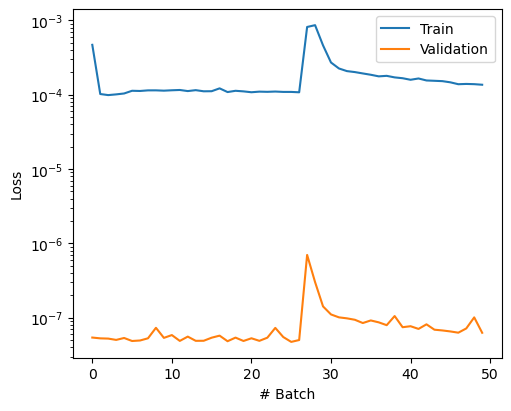

In [24]:
# train 
learning_rate = 1e-3
n_epoch = 50
batch_size = 2048
l2 = 1e-4

trainer = GNNTrainer(net, batch_size, learning_rate, n_epoch, l2)
trainer.train(graph_ani_train_loader, graph_ani_val_loader)

6.451507583219832e-08

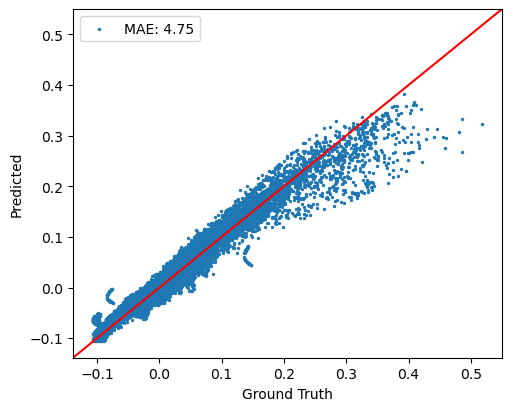

In [25]:
trainer.evaluate(graph_ani_test_loader)

In [12]:
node_input_dim = graph_train.dataset[0].x.shape[1]
edge_input_dim = graph_train.dataset[0].edge_attr.shape[1]

In [15]:
node_hidden_dim = 128
edge_hidden_dim = 128

net = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim).to(device)

In [15]:
graph_train_list = [graph_train_1, graph_train_2, graph_train_3, graph_train_4]

In [16]:
def check_dataloader_device(dataloader):
    loop = 0
    for batch_data in dataloader:
        # Print the device of each tensor in the batch
        print("Node features device:", batch_data.x.device)
        print("Edge features device:", batch_data.edge_attr.device)
        print("Edge index device:", batch_data.edge_index.device)
        print("Target tensor device:", batch_data.y.device)
        loop += 1
        if loop >= 3:
            return 

# Assuming graph_train_loader is your DataLoader
check_dataloader_device(graph_train)

Node features device: cuda:0
Edge features device: cuda:0
Edge index device: cuda:0
Target tensor device: cuda:0
Node features device: cuda:0
Edge features device: cuda:0
Edge index device: cuda:0
Target tensor device: cuda:0
Node features device: cuda:0
Edge features device: cuda:0
Edge index device: cuda:0
Target tensor device: cuda:0


GraphNet - Number of parameters: 84609


100%|██████████| 50/50 [1:01:12<00:00, 73.45s/it] 


[array(0.0029157, dtype=float32),
 array(0.00384375, dtype=float32),
 array(0.00260933, dtype=float32),
 array(0.00277813, dtype=float32),
 array(0.00259892, dtype=float32),
 array(0.00237202, dtype=float32),
 array(0.00231348, dtype=float32),
 array(0.00252627, dtype=float32),
 array(0.00249178, dtype=float32),
 array(0.0022276, dtype=float32),
 array(0.00230725, dtype=float32),
 array(0.00250707, dtype=float32),
 array(0.00244033, dtype=float32),
 array(0.00233226, dtype=float32),
 array(0.00229282, dtype=float32),
 array(0.0022483, dtype=float32),
 array(0.00219979, dtype=float32),
 array(0.00250606, dtype=float32),
 array(0.0022709, dtype=float32),
 array(0.00230809, dtype=float32),
 array(0.00240601, dtype=float32),
 array(0.00225652, dtype=float32),
 array(0.00223784, dtype=float32),
 array(0.00230702, dtype=float32),
 array(0.0023187, dtype=float32),
 array(0.00229485, dtype=float32),
 array(0.00239114, dtype=float32),
 array(0.00236081, dtype=float32),
 array(0.0022558, dtype=f

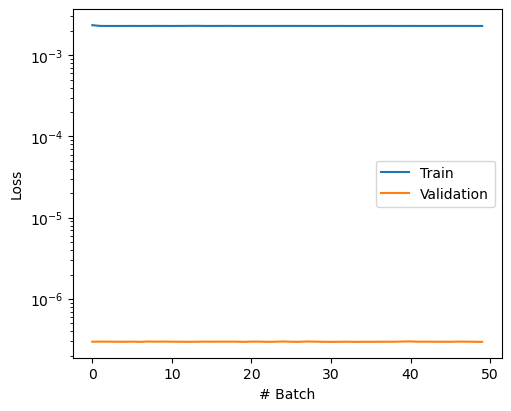

In [28]:
# train 
learning_rate = 1e-3
n_epoch = 50
batch_size = 16384
l2 = 1e-4

trainer = GNNTrainer(net, batch_size, learning_rate, n_epoch, l2)
trainer.train(graph_train, graph_val)

2.88085686718791e-07

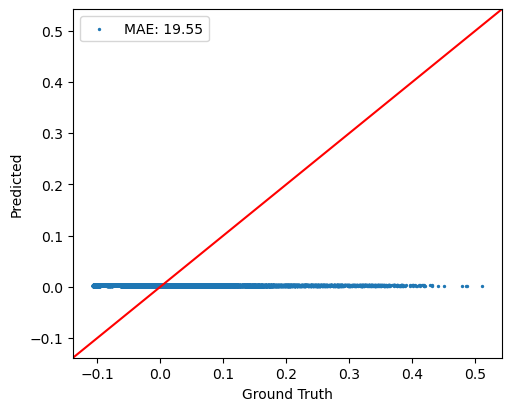

In [29]:
trainer.evaluate(graph_test)
#trainer.evaluate(dev_graph_train)

In [13]:
class ANITrainer:
    def __init__(self, model, batch_size, epoch, opt_method="adam", loss_func=nn.MSELoss(), learning_rate=1e-3, l2=1e-9):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        self.epoch = epoch
        self.batch_size = batch_size
        #Generally MSE is better than cross-entropy for regression, so it is the default
        
        self.loss = loss_func
        self.batch_size = batch_size
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size).cache()
        #val_data_loader = val_data.collate(batch_size).cache()
        
        # definition of loss function: MSE is a good choice! 
        loss_func = self.loss
        
        # record epoch losses
        train_loss_list, val_loss_list, lowest_val_loss = [], [], np.inf

        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                #print("computing energies...")
                # compute energies
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                _, pred_energies = model((species, coords))
                
                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = pred_energies.shape[0]/len(train_data)
                train_epoch_loss += batch_loss.detach().to(device).item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data, draw_plot=False)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)

            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            x_axis = np.arange(self.epoch)
            # Plot train loss and validation loss
            ax.plot(x_axis, train_loss_list, label='Train')
            ax.plot(x_axis, val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        self.model.eval()
        #print("evaluate has been called")
        # init data loader
        data_loader = data.collate(batch_size).cache()
        
        # init loss function
        loss_func = self.loss
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                _, pred_energies = model((species, coords))
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = pred_energies.shape[0] / len(data)
                total_loss += batch_loss.detach().to(device).item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

In [14]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

In [15]:
class wideAtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = wideAtomicNet()
net_C = wideAtomicNet()
net_N = wideAtomicNet()
net_O = wideAtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
wide_ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    wide_ani_net
).to(device)

In [16]:
class deepAtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = deepAtomicNet()
net_C = deepAtomicNet()
net_N = deepAtomicNet()
net_O = deepAtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
deep_ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    deep_ani_net
).to(device)

In [10]:
class bigAtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.layers(x)

net_H = bigAtomicNet()
net_C = bigAtomicNet()
net_N = bigAtomicNet()
net_O = bigAtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
big_ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    big_ani_net
).to(device)       

I decided not to use the "bigAtomicNet" class: it performed much better on my small debugging datasets, but was too computationally expensive to use here.  "deepAtomicNet" already has great performance.

In [17]:
# Instantiate the ANITrainer with the model, batch_size, epoch, and other necessary parameters
epoch = 100
batch_size = 2048
trainer = ANITrainer(model=model, batch_size=batch_size, epoch=epoch, opt_method="adam", loss_func=nn.MSELoss(), learning_rate=1e-3, l2=1e-9)

Sequential - Number of parameters: 329732


Initialize training data...


100%|██████████| 100/100 [20:15<00:00, 12.15s/it]


1.0547970598648817e-06

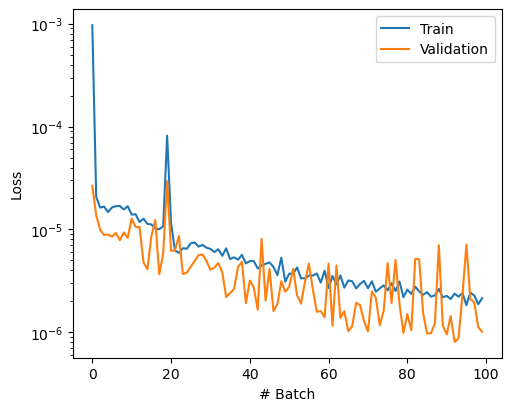

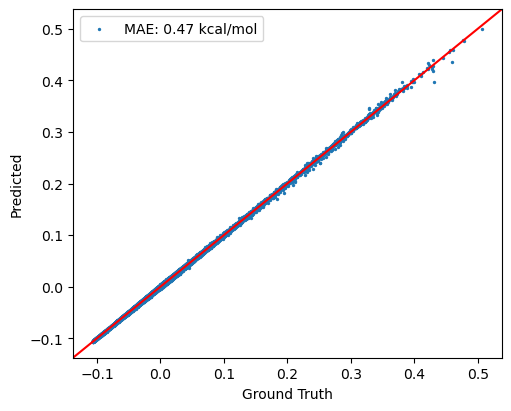

In [18]:
# Train the model using the train_data_loader and val_data_loader
train_loss_list, val_loss_list = trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
trainer.evaluate(test_data, draw_plot=True)

2.8398482470838087e-05

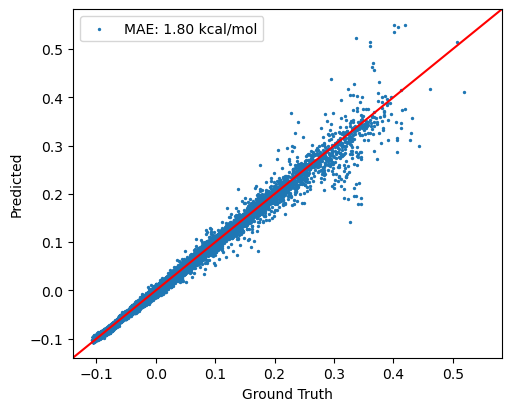

In [920]:
trainer.evaluate(test_data, draw_plot=True)